## **LIBRARY IMPORTS**

In [1]:
# Import Libraries
import cudf
import os
import joblib
import pywt
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb  # For reading MIT-BIH data
import keras_tuner as kt
import seaborn as sns
import tensorflow as tf
import neurokit2 as nk

# Scikit-learn and Imbalanced-learn imports
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score
)
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.stats import entropy
from collections import Counter
from scipy.signal import find_peaks, resample, butter, filtfilt, iirnotch, spectrogram
from sklearn.utils import class_weight
from glob import glob

# Model imports
from sklearn.svm import SVC
from imblearn.ensemble import BalancedRandomForestClassifier
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, MaxPooling1D, Dropout, Add, GlobalAveragePooling1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from cuml.ensemble import RandomForestClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.utils.class_weight import compute_class_weight

# Additional setups
# Checking cUML
print(cudf.Series([1, 2, 3]))

# Setting TensorFlow flags
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Checking GPU
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print(f"TensorFlow has detected {len(gpu_devices)} GPU(s):")
    for device in gpu_devices:
        print(f"- {device}")
else:
    print("TensorFlow did not detect any GPUs. Training will run on the CPU.")


2025-08-30 18:48:35.635297: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-30 18:48:36.323478: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756554516.520064     496 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756554516.585256     496 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756554517.097764     496 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

0    1
1    2
2    3
dtype: int64
TensorFlow has detected 1 GPU(s):
- PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## **DATA PREPARATION**

### DATA PREPARATION FUNCTIONS
There are 3 types of functions:
1. Labels and windowed features of the RR intervals
2. Data preparation of MIT-BIH dataset as training and validation set
3. Data preparation of additional ECG data with a format of .bin as the final testing set

In [2]:
label_map = {
    'N': 0, '.': 0, 'L': 0, 'R': 0, 'e': 0, 'j': 0,  # Class 0: Normal Beats (N)
    'V': 1, 'E': 1,                                  # Class 1: Ventricular Ectopic (VEB)
    'S': 2, 'A': 2, 'a': 2, 'J': 2,                  # Class 2: Supraventricular Ectopic (SVEB)
    'F': 3                                           # Class 3: Fusion Beat (F)
}

DB_PATH_MIT = '../data/raw/MIT-BIH/mit-bih-arrhythmia-database-1.0.0/mit-bih-arrhythmia-database-1.0.0/'

FS_MIT = 360
FS_TARGET = 500
WINDOW_SIZE = int(FS_TARGET*0.8)  # 400 samples -> 0.8s * 500Hz
# Split MIT-BIH records into training and testing sets to prevent patient data leakage
RECORDS_TRAIN = ['101', '106', '108', '109', '112', '114', '115', '116', '118', '119',
                 '122', '124', '201', '203', '205', '207', '208', '209', '215', '220',
                 '223', '230'] # DS1
RECORDS_TEST = ['100', '103', '105', '111', '113', '117', '121', '123', '200', '202',
                '210', '212', '213', '214', '219', '221', '222', '228', '231', '232',
                '233', '234'] # DS2
custom_file_paths = {
    'Arrhythmia': '../data/raw/Arrhythmia/ECG_WAVE.bin',
    'Normal': '../data/raw/Normal/ecg_normal.bin'
}
custom_file_labels = {'Arrhythmia': 2, 'Normal': 0} # SVEB and Normal

# Wavelet Feature Configuration
WAVELET_TYPE = 'db4'
WAVELET_LEVEL = 4

# Define the output directory
output_dir_prepare_data = '../data/processed'
os.makedirs(output_dir_prepare_data, exist_ok=True)

def preprocess_signal(signal, fs):
    """Applies a multi-stage denoising pipeline to a raw ECG signal."""
    signal = np.array(signal)
    nyq = 0.5 * fs
    low_cutoff = 0.6
    b, a = butter(2, low_cutoff / nyq, btype='high')
    signal_bw_removed = filtfilt(b, a, signal)
    powerline_freq = 50
    b, a = iirnotch(powerline_freq / nyq, Q=30)
    signal_pl_removed = filtfilt(b, a, signal_bw_removed)
    high_cutoff = 100
    b, a = butter(4, high_cutoff / nyq, btype='low')
    cleaned_signal = filtfilt(b, a, signal_pl_removed)
    return cleaned_signal

def extract_dwt_features(window, wavelet, level):
    """Extracts statistical features from the DWT coefficients."""
    coeffs = pywt.wavedec(window, wavelet, level=level) # Use wavedec for DWT
    features = []
    for c in coeffs:
        features.append(np.mean(c))
        features.append(np.std(c))
        features.append(np.var(c))
        features.append(np.sum(np.square(c)))
        features.append(entropy(np.square(c) + 1e-9))
    return np.array(features)

def extract_rr_interval_features(r_peaks, current_beat_index, fs):
    """
    Calculates RR interval features for a given heartbeat.
    """
    pre_rr_samples = r_peaks[current_beat_index] - r_peaks[current_beat_index - 1]
    pre_rr_seconds = pre_rr_samples / fs

    post_rr_samples = r_peaks[current_beat_index + 1] - r_peaks[current_beat_index]
    post_rr_seconds = post_rr_samples / fs

    local_window_start = max(0, current_beat_index - 10)
    local_r_peaks = r_peaks[local_window_start:current_beat_index + 1]
    
    if len(local_r_peaks) > 1:
        local_rr_intervals = np.diff(local_r_peaks) / fs
        local_avg_rr = np.mean(local_rr_intervals)
    else:
        local_avg_rr = pre_rr_seconds

    ratio_rr = pre_rr_seconds / (local_avg_rr + 1e-9)

    return np.array([pre_rr_seconds, post_rr_seconds, local_avg_rr, ratio_rr])

def calculate_specificity(y_true, y_pred, classes):
    """Calculates macro-averaged specificity from a confusion matrix."""
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    num_classes = len(classes)
    specificities = []
    for i in range(num_classes):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)
        
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        specificities.append(specificity)
        
    return np.mean(specificities)

# Visualization Function
def visualize_preprocessing_result(raw_signal, fs, record_name=""):
    """
    Applies preprocessing and plots the raw vs. cleaned signal for comparison.
    """
    print(f"Visualizing preprocessing for record: {record_name} (first 10 seconds)...")
    
    duration_in_seconds = 10
    snippet_length = int(duration_in_seconds * fs)
    raw_snippet = raw_signal[:snippet_length]

    cleaned_snippet = preprocess_signal(raw_snippet, fs=fs)

    time_axis = np.arange(len(raw_snippet)) / fs

    plt.figure(figsize=(15, 6))
    plt.plot(time_axis, raw_snippet, label='Raw Signal', color='blue', alpha=0.7)
    plt.plot(time_axis, cleaned_snippet, label='Cleaned Signal', color='red', linewidth=1.5)
    plt.title(f'ECG Signal Preprocessing Result for Record {record_name}')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude (mV)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

In [3]:
# 2. DATA LOADING UTILITIES
def load_mitbih_records(db_path, record_names):
    """REVERTED: Loads raw ECG signals (two leads) and annotations."""
    signals_leadA, signals_leadB, all_annotations = [], [], []
    print(f"Loading MIT-BIH records (two leads): {', '.join(record_names)}...")
    for rec_name in record_names:
        record_path = os.path.join(db_path, rec_name)
        try:
            # Load both channels
            record = wfdb.rdrecord(record_path, channels=[0, 1])
            signals_leadA.append(record.p_signal[:, 0].flatten())
            signals_leadB.append(record.p_signal[:, 1].flatten())
            annotation = wfdb.rdann(record_path, 'atr')
            all_annotations.append(annotation)
        except Exception as e:
            print(f"Error processing record {rec_name}: {e}")
    print("Loading complete.")
    return signals_leadA, signals_leadB, all_annotations

def load_ecg_from_bin(file_path, dtype=np.int16):
    """Loading raw ECG signals from binary files."""
    try:
        signal = np.fromfile(file_path, dtype=dtype)
        print(f"Completed reading {len(signal)} samples from {file_path}")
        return signal
    except IOError as e:
        print(f"An error has occurred while reading: {e}")
        return None

def detect_r_peaks_robust(signal, fs):
    """Detects R-peaks using a robust algorithm from NeuroKit2."""
    try:
        _, rpeaks_dict = nk.ecg_peaks(signal, sampling_rate=fs)
        r_peaks = rpeaks_dict['ECG_R_Peaks']
        return r_peaks
    except Exception as e:
        return np.array([])

In [4]:
# 3. DATA PREPARATION FUNCTIONS
def prepare_features_and_raw_data(signals_A, signals_B, annotations, window_size, fs=360, target_fs=500):
    """REVERTED: Processes dual-lead MIT-BIH data to generate features and raw windows."""
    all_combined_features, all_raw_windows, all_labels = [], [], []
    samples_before = window_size // 3
    samples_after = window_size - samples_before

    for i, (raw_signal_A, raw_signal_B) in enumerate(zip(signals_A, signals_B)):
        ann = annotations[i]
        try:
            cleaned_A_orig_fs = preprocess_signal(raw_signal_A, fs=fs)
            cleaned_B_orig_fs = preprocess_signal(raw_signal_B, fs=fs)

            cleaned_A = resample(cleaned_A_orig_fs, int(len(cleaned_A_orig_fs) * (target_fs / fs)))
            cleaned_B = resample(cleaned_B_orig_fs, int(len(cleaned_B_orig_fs) * (target_fs / fs)))
            
            r_peaks_resampled = np.round(ann.sample * (target_fs / fs)).astype(int)

            for j in range(1, len(r_peaks_resampled) - 1):
                r_peak_loc = r_peaks_resampled[j]
                symbol = ann.symbol[j]
                if symbol in label_map:
                    start, end = r_peak_loc - samples_before, r_peak_loc + samples_after
                    if start >= 0 and end < len(cleaned_A):
                        window_A = cleaned_A[start:end]
                        window_B = cleaned_B[start:end]
                        
                        dwt_A = extract_dwt_features(window_A, WAVELET_TYPE, WAVELET_LEVEL)
                        dwt_B = extract_dwt_features(window_B, WAVELET_TYPE, WAVELET_LEVEL)
                        morph_features = np.concatenate((dwt_A, dwt_B))

                        rr_features = extract_rr_interval_features(r_peaks_resampled, j, fs=target_fs)
                        
                        combined_features = np.concatenate((morph_features, rr_features))
                        all_combined_features.append(combined_features)
                        # Stack the two leads for the raw data
                        all_raw_windows.append(np.stack((window_A, window_B), axis=-1))
                        all_labels.append(label_map[symbol])
        except Exception as e:
            print(f"Could not process record {ann.record_name}: {e}")
    return np.array(all_combined_features), np.array(all_raw_windows), np.array(all_labels)

def prepare_features_and_raw_data_from_bin(signal, r_peaks, window_size, label, target_fs=500):
    """REVERTED: Processes a single-lead .bin file, duplicating channels for dual-lead models."""
    all_combined_features, all_raw_windows, all_labels = [], [], []
    samples_before = window_size // 3
    samples_after = window_size - samples_before
    cleaned_signal = preprocess_signal(signal, fs=target_fs)

    for j in range(1, len(r_peaks) - 1):
        r_peak_loc = r_peaks[j]
        start, end = r_peak_loc - samples_before, r_peak_loc + samples_after
        if start >= 0 and end < len(cleaned_signal):
            window = cleaned_signal[start:end]
            
            dwt_features = extract_dwt_features(window, WAVELET_TYPE, WAVELET_LEVEL)
            # Duplicate features for dual-lead format
            morph_features = np.concatenate((dwt_features, dwt_features))
            rr_features = extract_rr_interval_features(r_peaks, j, fs=target_fs)
            
            all_combined_features.append(np.concatenate((morph_features, rr_features)))
            # Duplicate and stack window for dual-lead format
            all_raw_windows.append(np.stack((window, window), axis=-1))
            all_labels.append(label)
            
    return np.array(all_combined_features), np.array(all_raw_windows), np.array(all_labels)

### DATA PREPARATION EXECUTION
1. Reading all ECG datasets
2. Divide all datasets into training dataset and testing dataset
3. Standard scaling and combining datasets
4. Splitting training dataset into training split and validation split then applying SMOTE algorithm into the training split
5. Preparing all the datasets for each machine learning model
The feature extraction of this data is transforming the data into wavelet data. Beforehand, the data was transformed into RR-intervals only data, but the data provided is limited to its RR-intervals and it didn't represent the heartbeat morphology of the data. Then, it was transformed into raw ECG data which is better than before, but the data was costly and thus needed further transformation. Lastly, it is transformed into wavelet data

--- [Step 1] Processing Dual-Lead MIT-BIH Data ---
Loading MIT-BIH records (two leads): 101, 106, 108, 109, 112, 114, 115, 116, 118, 119, 122, 124, 201, 203, 205, 207, 208, 209, 215, 220, 223, 230...
Loading complete.
Visualizing preprocessing for record: 101 (first 10 seconds)...


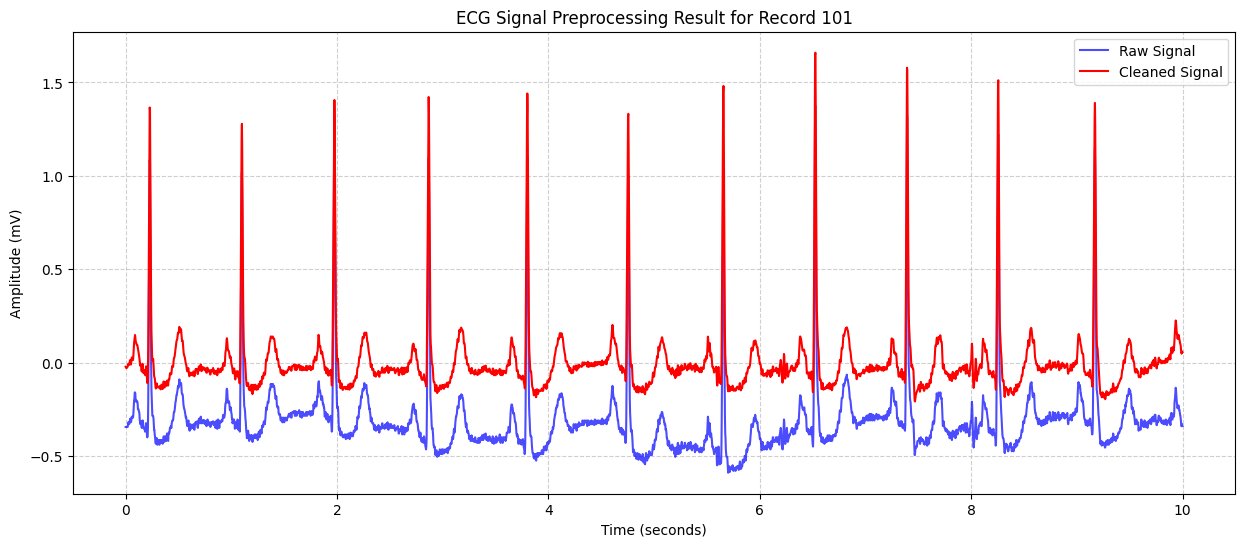

Loading MIT-BIH records (two leads): 100, 103, 105, 111, 113, 117, 121, 123, 200, 202, 210, 212, 213, 214, 219, 221, 222, 228, 231, 232, 233, 234...
Loading complete.

--- [Step 2] Processing Single-Lead Custom Data for Testing ---
Completed reading 2380000 samples from ../data/raw/Arrhythmia/ECG_WAVE.bin
Completed reading 2135000 samples from ../data/raw/Normal/ecg_normal.bin

--- [Step 3] Finalizing Datasets and Scaling ---
Training data shapes before splitting:
Features: (50983, 54), Raw: (50983, 400, 2), Labels: (50983,)
Scaler trained on MIT-BIH training features.

--- [Step 4] Finalizing Training Data (Split & SMOTE Sample) ---
Applying SMOTE to feature training data...
Class distribution before sampling: Counter({np.int64(0): 36670, np.int64(1): 3030, np.int64(2): 755, np.int64(3): 331})
Class distribution after sampling: Counter({np.int64(1): 36670, np.int64(0): 36670, np.int64(2): 36670, np.int64(3): 36670})

--- [Step 5] Preparing Final Datasets for Models ---

✅ DATA PREPARA

In [5]:
if __name__ == '__main__':
    # --- [Step 1] Process MIT-BIH Data ---
    print("--- [Step 1] Processing Dual-Lead MIT-BIH Data ---")
    train_signals_A, train_signals_B, train_anns = load_mitbih_records(DB_PATH_MIT, RECORDS_TRAIN)
    
    if train_signals_A:
        visualize_preprocessing_result(train_signals_A[0], fs=FS_MIT, record_name=RECORDS_TRAIN[0])

    X_train_features_base, X_train_raw_base, y_train = prepare_features_and_raw_data(train_signals_A, train_signals_B, train_anns, WINDOW_SIZE, fs=FS_MIT, target_fs=FS_TARGET)

    test_signals_A, test_signals_B, test_anns = load_mitbih_records(DB_PATH_MIT, RECORDS_TEST)
    X_test_features_mit, X_test_raw_mit, y_test_mitbih = prepare_features_and_raw_data(test_signals_A, test_signals_B, test_anns, WINDOW_SIZE, fs=FS_MIT, target_fs=FS_TARGET)

    # --- [Step 2] Process Single-Lead Custom Data for TESTING ---
    print("\n--- [Step 2] Processing Single-Lead Custom Data for Testing ---")
    X_test_custom_features_list, X_test_custom_raw_list, y_test_custom_list = [], [], []
    for name, path in custom_file_paths.items():
        signal = load_ecg_from_bin(path)
        if signal is not None:
            r_peaks = detect_r_peaks_robust(signal, fs=FS_TARGET)
            features_single, raw_single, y_single = prepare_features_and_raw_data_from_bin(
                signal, r_peaks, WINDOW_SIZE, custom_file_labels[name], target_fs=FS_TARGET
            )
            X_test_custom_features_list.append(features_single)
            X_test_custom_raw_list.append(raw_single)
            y_test_custom_list.append(y_single)
            
    X_test_custom_features = np.vstack(X_test_custom_features_list)
    X_test_custom_raw = np.vstack(X_test_custom_raw_list)
    y_test_custom = np.concatenate(y_test_custom_list)

    # --- [Step 3] Finalize Datasets and Scale Feature data ---
    print("\n--- [Step 3] Finalizing Datasets and Scaling ---")
    print(f"Training data shapes before splitting:")
    print(f"Features: {X_train_features_base.shape}, Raw: {X_train_raw_base.shape}, Labels: {y_train.shape}")
    
    scaler = StandardScaler()
    X_train_features_scaled = scaler.fit_transform(X_train_features_base)
    print("Scaler trained on MIT-BIH training features.")
    
    if X_test_features_mit.size > 0:
        X_test_features_mit_scaled = scaler.transform(X_test_features_mit)
    else:
        X_test_features_mit_scaled = X_test_features_mit

    if X_test_custom_features.size > 0:
        X_test_features_custom_scaled = scaler.transform(X_test_custom_features)
    else:
        X_test_features_custom_scaled = X_test_custom_features
    
    X_test_features_final = np.concatenate((X_test_features_mit_scaled, X_test_features_custom_scaled), axis=0)
    X_test_raw_final = np.concatenate((X_test_raw_mit, X_test_custom_raw), axis=0)
    y_test_final = np.concatenate((y_test_mitbih, y_test_custom), axis=0)
    
    # --- [Step 4] Splitting & Sampling for Feature data ---
    print("\n--- [Step 4] Finalizing Training Data (Split & SMOTE Sample) ---")
    X_train_features_fold, X_val_features_fold, y_train_fold, y_val_fold = train_test_split(
        X_train_features_scaled, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    X_train_raw_fold, X_val_raw_fold, _, _ = train_test_split(
        X_train_raw_base, y_train, test_size=0.2, random_state=42, stratify=y_train
    )

    print("Applying SMOTE to feature training data...")
    print("Class distribution before sampling:", Counter(y_train_fold))
    sampler = SMOTE(random_state=42)
    X_train_features_resampled, y_train_features_resampled = sampler.fit_resample(X_train_features_fold, y_train_fold)
    print("Class distribution after sampling:", Counter(y_train_features_resampled))

    # --- [Step 5] Final Data Preparation for Models ---
    print("\n--- [Step 5] Preparing Final Datasets for Models ---")
    output_dim = len(np.unique(y_train))
    
    # Data for MLP
    X_train_mlp, y_train_mlp = X_train_features_resampled, to_categorical(y_train_features_resampled, num_classes=output_dim)
    X_val_mlp, y_val_mlp = X_val_features_fold, to_categorical(y_val_fold, num_classes=output_dim)
    X_test_mlp, y_test_mlp = X_test_features_final, to_categorical(y_test_final, num_classes=output_dim)

    # Data for 1D-CNN
    X_train_cnn, y_train_cnn = X_train_raw_fold, to_categorical(y_train_fold, num_classes=output_dim)
    X_val_cnn, y_val_cnn = X_val_raw_fold, to_categorical(y_val_fold, num_classes=output_dim)
    X_test_cnn, y_test_cnn = X_test_raw_final, to_categorical(y_test_final, num_classes=output_dim)

    # Data for RandomForest
    X_train_rf, y_train_rf = X_train_features_resampled, y_train_features_resampled
    X_val_rf, y_val_rf = X_val_features_fold, y_val_fold
    X_test_rf, y_test_rf = X_test_features_final, y_test_final

    print("\n" + "="*60)
    print("✅ DATA PREPARATION COMPLETE ✅")
    print(f"Shapes for MLP -> Train: {X_train_mlp.shape}, Val: {X_val_mlp.shape}, Test: {X_test_mlp.shape}")
    print(f"Shapes for 1D-CNN -> Train: {X_train_cnn.shape}, Val: {X_val_cnn.shape}, Test: {X_test_cnn.shape}")
    print(f"Shapes for RandomForest -> Train: {X_train_rf.shape}, Val: {X_val_rf.shape}, Test: {X_test_rf.shape}")
    print("="*60)

## **MACHINE LEARNING MODEL TRAINING & SAVING**

### MACHINE LEARNING MODEL FUNCTIONS
There are 3 models that will be trained:
1. MLP Model (TA242501010)
2. 1D-CNN
3. BalancedRandomForest

There is also an additional function in order to do automatic hyperparameter tuning, but the function is only made for the MLP model.

In [6]:
# Function to create the MLP model for cross-validation
def create_mlp_model(input_dim, output_dim):
    """Creates and compiles a Keras MLP model."""
    model = Sequential([
        # Hyperparameters tuning
        Dense(512, input_dim=input_dim, activation='relu'),
        Dropout(0.1),
        Dense(512, activation='relu'),
        Dropout(0.4),
        Dense(output_dim, activation='softmax') # Softmax for multi-class classification
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy', # Suitable for one-hot labels
        metrics=[
            #'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.F1Score(average='weighted', name='f1_score'),
            tf.keras.metrics.SpecificityAtSensitivity(0.9, name='specificity')
        ]
    )
    return model

def create_cnn_model(input_shape, output_dim, hp=None):
    """
    Creates and compiles an optimized 1D-CNN model.
    If 'hp' is provided, it builds a tunable model for KerasTuner.
    Otherwise, it builds a model with default hyperparameters.
    """
    # Define a default hyperparameter object if none is passed
    if hp is None:
        hp = kt.HyperParameters()
        # Set default values for when not tuning
        hp.values['conv4_filters'] = 64
        hp.values['dense_units'] = 512
        hp.values['learning_rate'] = 0.0001

    inputs = Input(shape=input_shape)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='valid', name='conv1d_1_freezed')(inputs)
    x = MaxPooling1D(pool_size=2, name='maxpool1d_1_freezed')(x)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', name='conv1d_2_freezed')(x)
    x = MaxPooling1D(pool_size=2, name='maxpool1d_2_freezed')(x)
    x = Conv1D(filters=4, kernel_size=3, activation='relu', padding='same', name='conv1d_3_freezed')(x)
    x = MaxPooling1D(pool_size=2, name='maxpool1d_3_freezed')(x)
    # ===============================================
    #           Trainable Layers
    # ===============================================
    x = Conv1D(filters=hp.values['conv4_filters'], kernel_size=3, activation='relu', padding='same', name='conv1d_4_trainable')(x)
    x = Flatten(name='flatten_layer')(x)
    x = Dense(units=hp.values['dense_units'], activation='relu', name='dense_1_trainable')(x)
    outputs = Dense(units=output_dim, activation='softmax', name='output_layer_trainable')(x)
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=Adam(learning_rate=hp.values['learning_rate']),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.F1Score(average='weighted', name='f1_score'),
            tf.keras.metrics.SpecificityAtSensitivity(0.9, name='specificity')
        ]
    )
    return model

# Function to create the RandomForest model
def create_rf_model():
    """Creates an instance of the GPU-accelerated RandomForestClassifier model using cuML."""
    # Hyperparameters are similar to imblearn's
    return RandomForestClassifier(
        n_estimators=200, 
        max_depth=30, 
        random_state=42
    )

def plot_confusion_matrix(y_true, y_pred, model_name):
    """Generates and displays a confusion matrix using Seaborn."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title(f'Confusion Matrix for Final {model_name} Model', fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()

### MACHINE LEARNING MODEL TRAINING EXECUTION
1. Targeted metrics: Precision, Recall, F1-Score, and Specificity
2. There are 3 executions: multiple models training (1D-CNN, BalancedRandomForest, and MLP), MLP model specific training, and MLP model automatic hyperparameter tuning
3. After training, all models immediately saved and exported into a certain folder


==================== MANUAL CLASS WEIGHT CALCULATION ====================
Manual Calculation Breakdown:
  Weight for Class 0 (Normal (N)): 50983 / (4 * 45838) = 0.2781
  Weight for Class 1 (Ventricular (V)): 50983 / (4 * 3788) = 3.3648
  Weight for Class 2 (Supraventricular (S)): 50983 / (4 * 943) = 13.5162
  Weight for Class 3 (Fusion (F)): 50983 / (4 * 414) = 30.7868

Final Calculated Class Weights to be used for 1D-CNN: {np.int64(0): 0.2780607792661111, np.int64(1): 3.364770327349525, np.int64(2): 13.516171792152704, np.int64(3): 30.78683574879227}


I0000 00:00:1756571764.701954     496 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3620 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
/mnt/c/Users/OSOTNAS/Documents/Kean/Others/KP_Xirka-Darma-Persada/machine-learning/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



==================== TRAINING MODEL: 1D-CNN ====================
Epoch 1/150


I0000 00:00:1756571771.204870     811 service.cc:152] XLA service 0x4c5aca40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756571771.206535     811 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2025-08-30 23:36:11.482312: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1756571772.062024     811 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-08-30 23:36:13.199392: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_676', 8 bytes spill stores, 8 bytes spill loads

2025-08-30 23:36:13.496761: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_d

  5/408 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.1026 - f1_score: 0.0654 - loss: 1.7613 - precision: 0.0000e+00 - recall: 0.0000e+00 - specificity: 0.0220    

I0000 00:00:1756571778.984594     811 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5713 - f1_score: 0.6297 - loss: 0.9035 - precision: 0.8398 - recall: 0.2897 - specificity: 0.5423

2025-08-30 23:36:24.022983: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_676', 4 bytes spill stores, 4 bytes spill loads

2025-08-30 23:36:24.337189: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_676', 8 bytes spill stores, 8 bytes spill loads

2025-08-30 23:36:24.658089: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_982', 36 bytes spill stores, 36 bytes spill loads



408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5717 - f1_score: 0.6302 - loss: 0.9029 - precision: 0.8399 - recall: 0.2903 - specificity: 0.5427

2025-08-30 23:36:32.112630: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_223', 4 bytes spill stores, 4 bytes spill loads

2025-08-30 23:36:32.143999: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_223', 8 bytes spill stores, 8 bytes spill loads



408/408 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - accuracy: 0.7524 - f1_score: 0.8051 - loss: 0.6551 - precision: 0.8964 - recall: 0.5472 - specificity: 0.7060 - val_accuracy: 0.8332 - val_f1_score: 0.8777 - val_loss: 0.6214 - val_precision: 0.8712 - val_recall: 0.7464 - val_specificity: 0.8702
Epoch 2/150
408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9008 - f1_score: 0.9223 - loss: 0.3619 - precision: 0.9227 - recall: 0.8661 - specificity: 0.9647 - val_accuracy: 0.9548 - val_f1_score: 0.9602 - val_loss: 0.2673 - val_precision: 0.9624 - val_recall: 0.9439 - val_specificity: 0.9928
Epoch 3/150
408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9315 - f1_score: 0.9448 - loss: 0.2672 - precision: 0.9432 - recall: 0.9122 - specificity: 0.9838 - val_accuracy: 0.9328 - val_f1_score: 0.9467 - val_loss: 0.3120 - val_precision: 0.9453 - val_recall: 0.9181 - val_specificity: 0.9853
Epoch 4/150
408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9390 - f1_score: 0.9510 - loss: 0.215

2025-08-30 23:46:59.480779: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_91', 4 bytes spill stores, 4 bytes spill loads

2025-08-30 23:46:59.589883: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_91', 4 bytes spill stores, 4 bytes spill loads



1532/1555 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2025-08-30 23:47:03.205904: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_107', 12 bytes spill stores, 12 bytes spill loads



1555/1555 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step

==================== TRAINING MODEL: RandomForest ====================

--- Evaluating model RandomForest on the test set... ---

==================== TRAINING MODEL: MLP ====================
Epoch 1/100
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - f1_score: 0.5343 - loss: 3.4530 - precision: 0.6676 - recall: 0.5717 - specificity: 0.4917

2025-08-30 23:47:23.564579: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_94', 484 bytes spill stores, 484 bytes spill loads

2025-08-30 23:47:23.591870: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_94', 3224 bytes spill stores, 3232 bytes spill loads

2025-08-30 23:47:23.864684: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_94', 8 bytes spill stores, 8 bytes spill loads

2025-08-30 23:47:24.111923: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_94_0', 1552 bytes spill stores, 1500 bytes spill loads

2025-08-30 23:47:24.401878: I external

1146/1146 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - f1_score: 0.6507 - loss: 1.6830 - precision: 0.7425 - recall: 0.6897 - specificity: 0.6838 - val_f1_score: 0.5153 - val_loss: 1.9198 - val_precision: 0.4005 - val_recall: 0.3586 - val_specificity: 0.3620
Epoch 2/100
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - f1_score: 0.8361 - loss: 0.4066 - precision: 0.8624 - recall: 0.8436 - specificity: 0.9204 - val_f1_score: 0.7055 - val_loss: 1.3480 - val_precision: 0.6123 - val_recall: 0.5856 - val_specificity: 0.6079
Epoch 3/100
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - f1_score: 0.8887 - loss: 0.2439 - precision: 0.9035 - recall: 0.8916 - specificity: 0.9642 - val_f1_score: 0.7889 - val_loss: 0.9878 - val_precision: 0.7241 - val_recall: 0.6935 - val_specificity: 0.7595
Epoch 4/100
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - f1_score: 0.9216 - loss: 0.1623 - precision: 0.9303 - recall: 0.9207 - specificity: 0.9832 - val_f1_score: 0.8558 - val_loss: 0.7612 - val_precision: 0.8100 - val_recall:

2025-08-30 23:53:51.874593: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16_0', 44 bytes spill stores, 44 bytes spill loads

2025-08-30 23:53:52.122741: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16', 484 bytes spill stores, 484 bytes spill loads



1513/1555 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

2025-08-30 23:53:55.043588: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16', 64 bytes spill stores, 64 bytes spill loads



1555/1555 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

========================= FINAL EVALUATION RESULTS =========================


~~~~~~~~~~~~~~~ REPORT FOR MODEL: 1D-CNN ~~~~~~~~~~~~~~~

Classification Report:
                      precision    recall  f1-score   support

          Normal (N)       0.96      0.81      0.88     44241
     Ventricular (V)       0.64      0.93      0.76      3220
Supraventricular (S)       0.12      0.35      0.18      1890
          Fusion (F)       0.02      0.11      0.03       388

            accuracy                           0.80     49739
           macro avg       0.43      0.55      0.46     49739
        weighted avg       0.90      0.80      0.84     49739



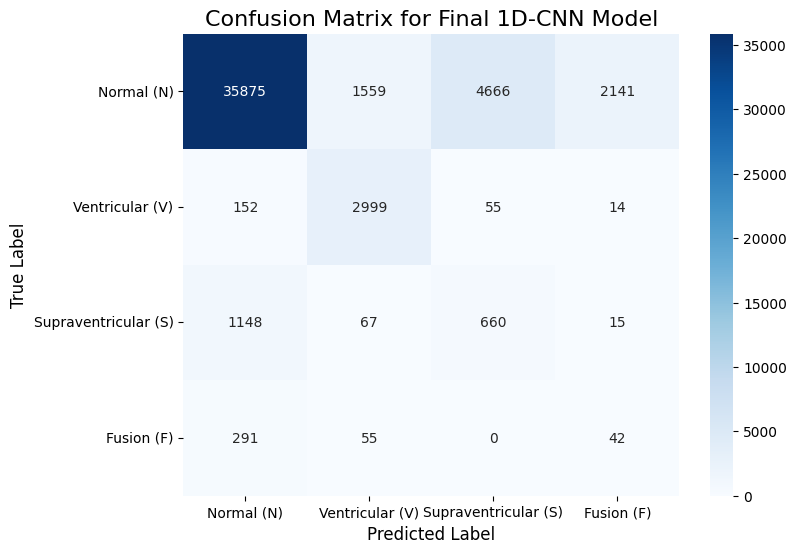

--- Saving model: 1D-CNN ---
✅ Model 1D-CNN has been saved to: ../models/model_1d-cnn_final.keras


~~~~~~~~~~~~~~~ REPORT FOR MODEL: RandomForest ~~~~~~~~~~~~~~~

Classification Report:
                      precision    recall  f1-score   support

          Normal (N)       0.95      0.97      0.96     44241
     Ventricular (V)       0.68      0.91      0.78      3220
Supraventricular (S)       0.26      0.04      0.07      1890
          Fusion (F)       0.00      0.00      0.00       388

            accuracy                           0.92     49739
           macro avg       0.47      0.48      0.45     49739
        weighted avg       0.90      0.92      0.91     49739



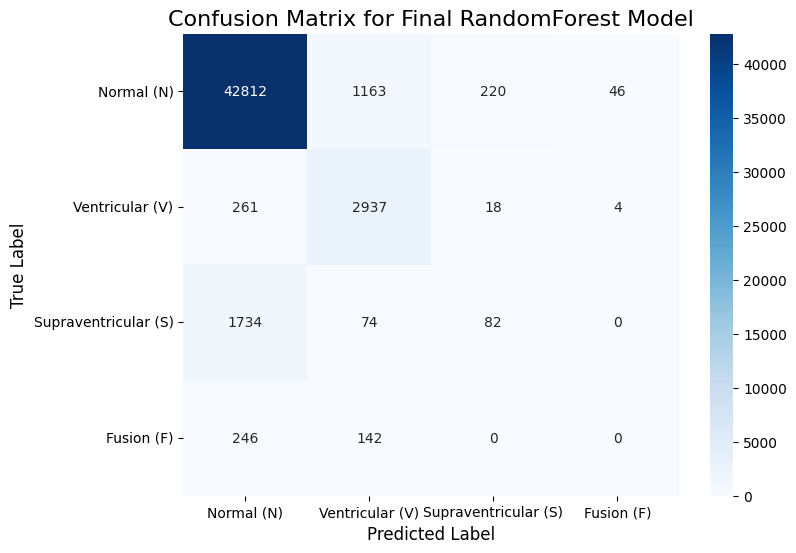

--- Saving model: RandomForest ---
✅ Model RandomForest has been saved to: ../models/model_randomforest_final.joblib


~~~~~~~~~~~~~~~ REPORT FOR MODEL: MLP ~~~~~~~~~~~~~~~

Classification Report:
                      precision    recall  f1-score   support

          Normal (N)       0.96      0.89      0.92     44241
     Ventricular (V)       0.64      0.89      0.74      3220
Supraventricular (S)       0.21      0.25      0.23      1890
          Fusion (F)       0.00      0.00      0.00       388

            accuracy                           0.86     49739
           macro avg       0.45      0.51      0.47     49739
        weighted avg       0.90      0.86      0.88     49739



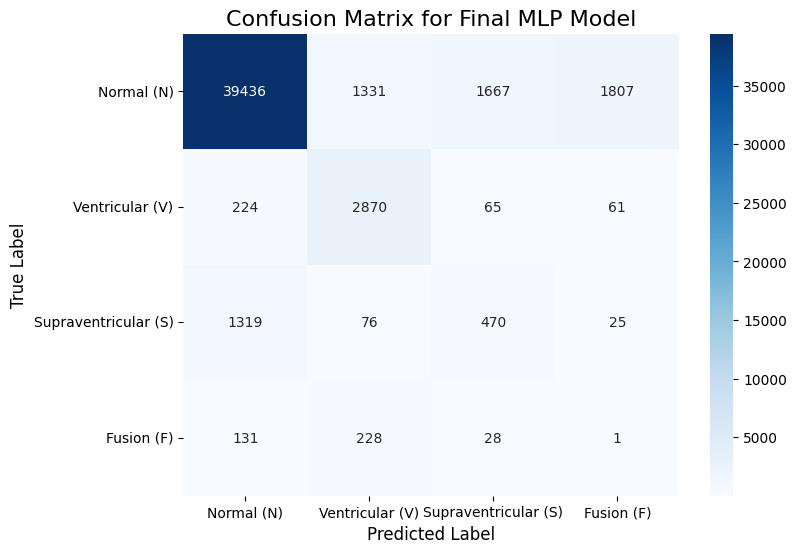

--- Saving model: MLP ---
✅ Model MLP has been saved to: ../models/model_mlp_final.keras


In [7]:
# --- Single-fold validation ---
# Define the output directory for saving the models and artifacts
OUTPUT_DIR = '../models'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Define class names for reporting and plotting
CLASS_NAMES = ['Normal (N)', 'Ventricular (V)', 'Supraventricular (S)', 'Fusion (F)']
# ==============================================================================
# --- MANUAL CLASS WEIGHT CALCULATION ---
# ==============================================================================
print("\n" + "="*20 + " MANUAL CLASS WEIGHT CALCULATION " + "="*20)

# We use the y_train data designated for the CNN before it's combined for CV
# This represents the original class distribution before any splits or sampling.
y_full_train_cnn_for_weights = np.argmax(np.concatenate((y_train_cnn, y_val_cnn), axis=0), axis=1)

n_samples = len(y_full_train_cnn_for_weights)
class_counts = Counter(y_full_train_cnn_for_weights)
n_classes = len(class_counts)

class_weights_dict = {}
print("Manual Calculation Breakdown:")
for i in sorted(class_counts.keys()):
    n_samples_in_class = class_counts[i]
    weight = n_samples / (n_classes * n_samples_in_class)
    class_weights_dict[i] = weight
    print(f"  Weight for Class {i} ({CLASS_NAMES[i]}): {n_samples} / ({n_classes} * {n_samples_in_class}) = {weight:.4f}")

print("\nFinal Calculated Class Weights to be used for 1D-CNN:", class_weights_dict)

# ==============================================================================
# --- TRAINING CONFIGURATION ---
# ==============================================================================
# Define model creation parameters
input_shape_cnn = (X_train_cnn.shape[1], X_train_cnn.shape[2])
input_dim_mlp = X_train_mlp.shape[1]
output_dim = y_train_cnn.shape[1]

# Create a dictionary of models to be trained
models = {
    "1D-CNN": create_cnn_model(input_shape_cnn, output_dim),
    "RandomForest": create_rf_model(),
    "MLP": create_mlp_model(input_dim_mlp, output_dim)
}

# Dictionary to store the final evaluation results
results = {}

# ==============================================================================
# --- TRAINING AND EVALUATING EACH MODEL ---
# ==============================================================================
for name, model in models.items():
    print(f"\n{'='*20} TRAINING MODEL: {name} {'='*20}")

    # --- Training Step ---
    if name == "1D-CNN":
        model.fit(
            X_train_cnn, y_train_cnn,
            epochs=150,
            batch_size=100,
            verbose=1,
            validation_data=(X_val_cnn, y_val_cnn),
            class_weight=class_weights_dict
        )
    elif name == "MLP":
        model.fit(
            X_train_mlp, y_train_mlp,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(X_val_mlp, y_val_mlp),
            class_weight=class_weights_dict # Applying weights as per user example
        )
    else:  # RandomForest
        model.fit(X_train_rf, y_train_rf)

    # --- Prediction Step on the Test Set ---
    print(f"\n--- Evaluating model {name} on the test set... ---")
    if name in ["MLP", "1D-CNN"]:
        # Use appropriate test data for each model
        X_test_data = X_test_mlp if name == "MLP" else X_test_cnn
        y_pred_raw = model.predict(X_test_data)
        y_pred = np.argmax(y_pred_raw, axis=1)
    else:  # RandomForest
        y_pred = model.predict(X_test_rf)

    # Store prediction results and ground truth for final reporting
    results[name] = {'y_pred': y_pred, 'y_true': y_test_final, 'model_instance': model}


# ==============================================================================
# --- [PART 3] FINAL REPORTING AND MODEL SAVING ---
# ==============================================================================
print(f"\n{'='*25} FINAL EVALUATION RESULTS {'='*25}")

for name, result_data in results.items():
    y_true = result_data['y_true']
    y_pred = result_data['y_pred']
    model_to_save = result_data['model_instance']

    print(f"\n\n{'~'*15} REPORT FOR MODEL: {name} {'~'*15}")

    # --- Classification Report ---
    print("\nClassification Report:")
    report = classification_report(y_true, y_pred, target_names=CLASS_NAMES, zero_division=0)
    print(report)

    # --- Confusion Matrix Visualization ---
    plot_confusion_matrix(y_true, y_pred, name)

    # --- Saving the Trained Model ---
    print(f"--- Saving model: {name} ---")
    if name in ["1D-CNN", "MLP"]:
        model_path = os.path.join(OUTPUT_DIR, f"model_{name.lower()}_final.keras")
        model_to_save.save(model_path)
        print(f"✅ Model {name} has been saved to: {model_path}")
    else:  # RandomForest
        model_path = os.path.join(OUTPUT_DIR, f"model_{name.lower()}_final.joblib")
        joblib.dump(model_to_save, model_path)
        print(f"✅ Model {name} has been saved to: {model_path}")

In [ ]:
# --- [SETUP] Define common variables and helper functions ---
# Define the output directory for saving the models and artifacts
OUTPUT_DIR = '../models'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Define class names for reporting and plotting
CLASS_NAMES = ['Normal (N)', 'Ventricular (V)', 'Supraventricular (S)', 'Fusion (F)']
N_SPLITS = 10 # Number of folds for cross-validation
# ==============================================================================
# --- MANUAL CLASS WEIGHT CALCULATION ---
# ==============================================================================
print("\n" + "="*20 + " MANUAL CLASS WEIGHT CALCULATION " + "="*20)

# We use the y_train data designated for the CNN before it's combined for CV
# This represents the original class distribution before any splits or sampling.
y_full_train_cnn_for_weights = np.argmax(np.concatenate((y_train_cnn, y_val_cnn), axis=0), axis=1)

n_samples = len(y_full_train_cnn_for_weights)
class_counts = Counter(y_full_train_cnn_for_weights)
n_classes = len(class_counts)

class_weights_dict = {}
print("Manual Calculation Breakdown:")
for i in sorted(class_counts.keys()):
    n_samples_in_class = class_counts[i]
    weight = n_samples / (n_classes * n_samples_in_class)
    class_weights_dict[i] = weight
    print(f"  Weight for Class {i} ({CLASS_NAMES[i]}): {n_samples} / ({n_classes} * {n_samples_in_class}) = {weight:.4f}")

print("\nFinal Calculated Class Weights to be used for 1D-CNN:", class_weights_dict)

# ==============================================================================
# --- [PART 1] MLP MODEL TRAINING & 10-FOLD CROSS-VALIDATION ---
# ==============================================================================

print("\n" + "="*25 + " MLP MODEL TRAINING " + "="*25)

# --- [1.1] Prepare Full Dataset for Cross-Validation ---
# Combine the initial training and validation sets created from SMOTE-resampled data
X_full_train_mlp = np.concatenate((X_train_mlp, X_val_mlp), axis=0)
y_full_train_mlp_cat = np.concatenate((y_train_mlp, y_val_mlp), axis=0)
y_full_train_mlp = np.argmax(y_full_train_mlp_cat, axis=1) # 1D labels for StratifiedKFold

input_dim_mlp = X_full_train_mlp.shape[1]
output_dim_mlp = y_full_train_mlp_cat.shape[1]

# --- [1.2] 10-Fold Cross-Validation ---
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
fold_metrics = {'loss': [], 'precision': [], 'recall': [], 'f1_score': []}

print(f"\n--- Starting {N_SPLITS}-Fold Cross-Validation for MLP ---")
for fold, (train_index, val_index) in enumerate(skf.split(X_full_train_mlp, y_full_train_mlp)):
    print(f"\n--- FOLD {fold + 1}/{N_SPLITS} ---")

    # Split data for the current fold
    X_train_fold, X_val_fold = X_full_train_mlp[train_index], X_full_train_mlp[val_index]
    y_train_fold_cat, y_val_fold_cat = y_full_train_mlp_cat[train_index], y_full_train_mlp_cat[val_index]

    # Create a new model instance for each fold to ensure independent training
    model_mlp = create_mlp_model(input_dim=input_dim_mlp, output_dim=output_dim_mlp)

    # Train the model
    print("Training...")
    model_mlp.fit(
        X_train_fold, y_train_fold_cat,
        epochs=100,
        batch_size=128,
        verbose=0,
        validation_data=(X_val_fold, y_val_fold_cat)
    )

    # Evaluate the fold
    results = model_mlp.evaluate(X_val_fold, y_val_fold_cat, verbose=0)
    fold_metrics['loss'].append(results[0])
    fold_metrics['precision'].append(results[1])
    fold_metrics['recall'].append(results[2])
    fold_metrics['f1_score'].append(results[3])
    
    print(f"Fold {fold + 1} - Val Loss: {results[0]:.4f}, Val F1-Score: {results[3]:.4f}")

# --- [1.3] Average Cross-Validation Results ---
print(f"\n{'='*20} MLP CV SUMMARY {'='*20}")
print(f"Average Validation Loss: {np.mean(fold_metrics['loss']):.4f} (+/- {np.std(fold_metrics['loss']):.4f})")
print(f"Average Validation F1-Score: {np.mean(fold_metrics['f1_score']):.4f} (+/- {np.std(fold_metrics['f1_score']):.4f})")
print(f"Average Validation Precision: {np.mean(fold_metrics['precision']):.4f} (+/- {np.std(fold_metrics['precision']):.4f})")
print(f"Average Validation Recall: {np.mean(fold_metrics['recall']):.4f} (+/- {np.std(fold_metrics['recall']):.4f})")


# --- [1.4] Final Model Training on ALL Data ---
print(f"\n{'='*20} TRAINING FINAL MLP MODEL ON ALL DATA {'='*20}")
final_model_mlp = create_mlp_model(input_dim=input_dim_mlp, output_dim=output_dim_mlp)
final_model_mlp.fit(
    X_full_train_mlp, y_full_train_mlp_cat,
    epochs=100,
    batch_size=128,
    verbose=1
)

# --- [1.5] Final Evaluation on the Hold-Out Test Set ---
print(f"\n{'='*20} FINAL MLP EVALUATION ON TEST SET {'='*20}")
y_pred_mlp_raw = final_model_mlp.predict(X_test_mlp)
y_pred_mlp = np.argmax(y_pred_mlp_raw, axis=1)
y_true_mlp = np.argmax(y_test_mlp, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_mlp, y_pred_mlp, target_names=CLASS_NAMES, zero_division=0))
plot_confusion_matrix(y_true_mlp, y_pred_mlp, "MLP")

# --- [1.6] Saving the Final Model ---
model_path = os.path.join(OUTPUT_DIR, "model_mlp_final.keras")
final_model_mlp.save(model_path)
print(f"✅ Final MLP Model has been saved to: {model_path}")

# ==============================================================================
# --- [PART 2] RANDOM FOREST MODEL TRAINING & 10-FOLD CROSS-VALIDATION ---
# ==============================================================================

print("\n" + "="*20 + " RANDOM FOREST MODEL TRAINING " + "="*20)

# --- [2.1] Prepare Full Dataset for Cross-Validation ---
# Combine initial training and validation sets. Labels are already 1D.
X_full_train_rf = np.concatenate((X_train_rf, X_val_rf), axis=0)
y_full_train_rf = np.concatenate((y_train_rf, y_val_rf), axis=0)

# --- [2.2] 10-Fold Cross-Validation ---
skf_rf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
fold_metrics_rf = {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}

print(f"\n--- Starting {N_SPLITS}-Fold Cross-Validation for RandomForest ---")
for fold, (train_index, val_index) in enumerate(skf_rf.split(X_full_train_rf, y_full_train_rf)):
    print(f"\n--- FOLD {fold + 1}/{N_SPLITS} ---")
    
    # Split data for the current fold
    X_train_fold, X_val_fold = X_full_train_rf[train_index], X_full_train_rf[val_index]
    y_train_fold, y_val_fold = y_full_train_rf[train_index], y_full_train_rf[val_index]

    # Create a new model instance for each fold
    model_rf = create_rf_model()

    # Train the model
    print("Training...")
    model_rf.fit(X_train_fold, y_train_fold)

    # Evaluate the fold
    y_pred_fold = model_rf.predict(X_val_fold)
    accuracy = accuracy_score(y_val_fold, y_pred_fold)
    precision = precision_score(y_val_fold, y_pred_fold, average='macro', zero_division=0)
    recall = recall_score(y_val_fold, y_pred_fold, average='macro', zero_division=0)
    f1 = f1_score(y_val_fold, y_pred_fold, average='macro', zero_division=0)
    
    fold_metrics_rf['accuracy'].append(accuracy)
    fold_metrics_rf['precision'].append(precision)
    fold_metrics_rf['recall'].append(recall)
    fold_metrics_rf['f1_score'].append(f1)
    
    print(f"Fold {fold + 1} - Val Accuracy: {accuracy:.4f}, Val Macro F1-Score: {f1:.4f}")

# --- [2.3] Average Cross-Validation Results ---
print(f"\n{'='*20} RANDOM FOREST CV SUMMARY {'='*20}")
print(f"Average Validation Accuracy: {np.mean(fold_metrics_rf['accuracy']):.4f} (+/- {np.std(fold_metrics_rf['accuracy']):.4f})")
print(f"Average Validation F1-Score: {np.mean(fold_metrics_rf['f1_score']):.4f} (+/- {np.std(fold_metrics_rf['f1_score']):.4f})")
print(f"Average Validation Precision: {np.mean(fold_metrics_rf['precision']):.4f} (+/- {np.std(fold_metrics_rf['precision']):.4f})")
print(f"Average Validation Recall: {np.mean(fold_metrics_rf['recall']):.4f} (+/- {np.std(fold_metrics_rf['recall']):.4f})")

# --- [2.4] Final Model Training on ALL Data ---
print(f"\n{'='*20} TRAINING FINAL RF MODEL ON ALL DATA {'='*20}")
final_model_rf = create_rf_model()
final_model_rf.fit(X_full_train_rf, y_full_train_rf)

# --- [2.5] Final Evaluation on the Hold-Out Test Set ---
print(f"\n{'='*20} FINAL RF EVALUATION ON TEST SET {'='*20}")
y_pred_rf = final_model_rf.predict(X_test_rf)
y_true_rf = y_test_rf # Test labels are already 1D

print("\nClassification Report:")
print(classification_report(y_true_rf, y_pred_rf, target_names=CLASS_NAMES, zero_division=0))
plot_confusion_matrix(y_true_rf, y_pred_rf, "RandomForest")

# --- [2.6] Saving the Final Model ---
model_path_rf = os.path.join(OUTPUT_DIR, "model_rf_final.joblib")
joblib.dump(final_model_rf, model_path_rf)
print(f"✅ Final RandomForest Model has been saved to: {model_path_rf}")

# ==============================================================================
# --- [PART 3] 1D-CNN MODEL TRAINING & 10-FOLD CROSS-VALIDATION ---
# ==============================================================================

print("\n" + "="*23 + " 1D-CNN MODEL TRAINING " + "="*23)

# --- [3.1] Prepare Full Dataset for Cross-Validation ---
# We use the raw, non-resampled data for the CNN and apply class weights
X_full_train_cnn = np.concatenate((X_train_cnn, X_val_cnn), axis=0)
y_full_train_cnn_cat = np.concatenate((y_train_cnn, y_val_cnn), axis=0)
y_full_train_cnn = np.argmax(y_full_train_cnn_cat, axis=1) # 1D labels for splitting

input_shape_cnn = (X_full_train_cnn.shape[1], X_full_train_cnn.shape[2])
output_dim_cnn = y_full_train_cnn_cat.shape[1]

# --- [3.2] 10-Fold Cross-Validation ---
skf_cnn = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
fold_metrics_cnn = {'loss': [], 'f1_score': [], 'precision': [], 'recall': []}

print(f"\n--- Starting {N_SPLITS}-Fold Cross-Validation for 1D-CNN ---")
for fold, (train_index, val_index) in enumerate(skf_cnn.split(X_full_train_cnn, y_full_train_cnn)):
    print(f"\n--- FOLD {fold + 1}/{N_SPLITS} ---")

    # Split data for the current fold
    X_train_fold, X_val_fold = X_full_train_cnn[train_index], X_full_train_cnn[val_index]
    y_train_fold_cat, y_val_fold_cat = y_full_train_cnn_cat[train_index], y_full_train_cnn_cat[val_index]
    
    # NOTE: We are now using the pre-calculated global class weights
    # No need to calculate weights inside the loop anymore.

    # Create a new model instance for each fold
    model_cnn = create_cnn_model(input_shape=input_shape_cnn, output_dim=output_dim_cnn)
    
    # Train the model
    print("Training with pre-calculated class weights...")
    model_cnn.fit(
        X_train_fold, y_train_fold_cat,
        epochs=150,
        batch_size=100,
        verbose=0,
        validation_data=(X_val_fold, y_val_fold_cat),
        class_weight=class_weights_dict
    )

    # Evaluate the fold
    results_cnn = model_cnn.evaluate(X_val_fold, y_val_fold_cat, verbose=0)
    fold_metrics_cnn['loss'].append(results_cnn[0])
    fold_metrics_cnn['precision'].append(results_cnn[1])
    fold_metrics_cnn['recall'].append(results_cnn[2])
    fold_metrics_cnn['f1_score'].append(results_cnn[3])
    
    print(f"Fold {fold + 1} - Val Loss: {results_cnn[0]:.4f}, Val F1-Score: {results_cnn[3]:.4f}")

# --- [3.3] Average Cross-Validation Results ---
print(f"\n{'='*20} 1D-CNN CV SUMMARY {'='*20}")
print(f"Average Validation Loss: {np.mean(fold_metrics_cnn['loss']):.4f} (+/- {np.std(fold_metrics_cnn['loss']):.4f})")
print(f"Average Validation F1-Score: {np.mean(fold_metrics_cnn['f1_score']):.4f} (+/- {np.std(fold_metrics_cnn['f1_score']):.4f})")
print(f"Average Validation Precision: {np.mean(fold_metrics_cnn['precision']):.4f} (+/- {np.std(fold_metrics_cnn['precision']):.4f})")
print(f"Average Validation Recall: {np.mean(fold_metrics_cnn['recall']):.4f} (+/- {np.std(fold_metrics_cnn['recall']):.4f})")

# --- [3.4] Final Model Training on ALL Data ---
print(f"\n{'='*20} TRAINING FINAL 1D-CNN MODEL ON ALL DATA {'='*20}")
# We use the same globally calculated weights for the final training.
print("Using Final Model Weights:", class_weights_dict)

final_model_cnn = create_cnn_model(input_shape=input_shape_cnn, output_dim=output_dim_cnn)
final_model_cnn.fit(
    X_full_train_cnn, y_full_train_cnn_cat,
    epochs=150,
    batch_size=100,
    verbose=1,
    class_weight=class_weights_dict
)

# --- [3.5] Final Evaluation on the Hold-Out Test Set ---
print(f"\n{'='*20} FINAL 1D-CNN EVALUATION ON TEST SET {'='*20}")
y_pred_cnn_raw = final_model_cnn.predict(X_test_cnn)
y_pred_cnn = np.argmax(y_pred_cnn_raw, axis=1)
y_true_cnn = np.argmax(y_test_cnn, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_cnn, y_pred_cnn, target_names=CLASS_NAMES, zero_division=0))
plot_confusion_matrix(y_true_cnn, y_pred_cnn, "1D-CNN")

# --- [3.6] Saving the Final Model ---
model_path_cnn = os.path.join(OUTPUT_DIR, "model_1d-cnn_final.keras")
final_model_cnn.save(model_path_cnn)
print(f"✅ Final 1D-CNN Model has been saved to: {model_path_cnn}")



==================== MANUAL CLASS WEIGHT CALCULATION ====================
Manual Calculation Breakdown:
  Weight for Class 0 (Normal (N)): 50983 / (4 * 45838) = 0.2781
  Weight for Class 1 (Ventricular (V)): 50983 / (4 * 3788) = 3.3648
  Weight for Class 2 (Supraventricular (S)): 50983 / (4 * 943) = 13.5162
  Weight for Class 3 (Fusion (F)): 50983 / (4 * 414) = 30.7868

Final Calculated Class Weights to be used for 1D-CNN: {np.int64(0): 0.2780607792661111, np.int64(1): 3.364770327349525, np.int64(2): 13.516171792152704, np.int64(3): 30.78683574879227}

========================= MLP MODEL TRAINING =========================

--- Starting 10-Fold Cross-Validation for MLP ---

--- FOLD 1/10 ---


/mnt/c/Users/OSOTNAS/Documents/Kean/Others/KP_Xirka-Darma-Persada/machine-learning/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training...


2025-08-31 04:37:57.647792: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_94', 488 bytes spill stores, 488 bytes spill loads

2025-08-31 04:37:57.724567: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_101', 4 bytes spill stores, 4 bytes spill loads

2025-08-31 04:37:58.249969: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_94_0', 1464 bytes spill stores, 1156 bytes spill loads

2025-08-31 04:37:58.344636: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_101', 8 bytes spill stores, 8 bytes spill loads

2025-08-31 04:37:58.346684: I external/loc

Fold 1 - Val Loss: 0.0125, Val F1-Score: 0.9981

--- FOLD 2/10 ---
Training...
Fold 2 - Val Loss: 0.0169, Val F1-Score: 0.9967

--- FOLD 3/10 ---
Training...
Fold 3 - Val Loss: 0.0214, Val F1-Score: 0.9974

--- FOLD 4/10 ---
Training...
Fold 4 - Val Loss: 0.0100, Val F1-Score: 0.9981

--- FOLD 5/10 ---
Training...
Fold 5 - Val Loss: 0.0149, Val F1-Score: 0.9976

--- FOLD 6/10 ---
Training...
Fold 6 - Val Loss: 0.0109, Val F1-Score: 0.9982

--- FOLD 7/10 ---
Training...
Fold 7 - Val Loss: 0.0180, Val F1-Score: 0.9974

--- FOLD 8/10 ---
Training...


2025-08-31 05:17:23.806419: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_101', 8 bytes spill stores, 8 bytes spill loads

2025-08-31 05:17:24.103832: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_101', 4 bytes spill stores, 4 bytes spill loads

2025-08-31 05:17:24.163243: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_94', 488 bytes spill stores, 488 bytes spill loads

2025-08-31 05:17:24.716553: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_94', 152 bytes spill stores, 152 bytes spill loads

2025-08-31 05:17:24.733691: I external/local_x

Fold 8 - Val Loss: 0.0251, Val F1-Score: 0.9976

--- FOLD 9/10 ---
Training...
Fold 9 - Val Loss: 0.0056, Val F1-Score: 0.9982

--- FOLD 10/10 ---
Training...
Fold 10 - Val Loss: 0.0112, Val F1-Score: 0.9979

==================== MLP CV SUMMARY ====================
Average Validation Loss: 0.0146 (+/- 0.0055)
Average Validation F1-Score: 0.9977 (+/- 0.0004)
Average Validation Precision: 0.9977 (+/- 0.0005)
Average Validation Recall: 0.9977 (+/- 0.0004)

==================== TRAINING FINAL MLP MODEL ON ALL DATA ====================
Epoch 1/100
1222/1226 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.8454 - loss: 0.4682 - precision: 0.9162 - recall: 0.7504 - specificity: 0.8957

2025-08-31 05:34:28.275287: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1094', 20 bytes spill stores, 20 bytes spill loads



1226/1226 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - f1_score: 0.9151 - loss: 0.2821 - precision: 0.9429 - recall: 0.8805 - specificity: 0.9767
Epoch 2/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - f1_score: 0.9691 - loss: 0.1086 - precision: 0.9722 - recall: 0.9658 - specificity: 0.9973
Epoch 3/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - f1_score: 0.9795 - loss: 0.0730 - precision: 0.9811 - recall: 0.9780 - specificity: 0.9987
Epoch 4/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - f1_score: 0.9852 - loss: 0.0544 - precision: 0.9860 - recall: 0.9840 - specificity: 0.9992
Epoch 5/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - f1_score: 0.9879 - loss: 0.0436 - precision: 0.9886 - recall: 0.9874 - specificity: 0.9994
Epoch 6/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - f1_score: 0.9897 - loss: 0.0366 - precision: 0.9901 - recall: 0.9893 - specificity: 0.9996
Epoch 7/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - f1_score: 0.9915 - loss: 0.0318 - precision: 0.9919 - recall: 0.99

In [ ]:
# Cukup panggil model.save() dan berikan nama folder tujuan.
CNN_folder = '../models/1D-CNN'
model_mlp.save(nama_folder_model)

print(f"\nModel MLP telah disimpan dalam folder: '{nama_folder_model}'")

# Gunakan joblib.dump() untuk menyimpan model ke dalam satu file
nama_file_model = 'model_brf.joblib'
joblib.dump(model_brf, nama_file_model)

print(f"\nModel telah disimpan sebagai file: '{nama_file_model}'")